# <span style="color:green"> Laboratorio di Simulazione Numerica </span>
## <span style="color:blue">  Esercitazione 7</span>

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math

L'esercitazione richiede di simulare il sistema di 108 molecole di Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) nell'ensemble canonico (NVT), campionando configurazioni del sistema attraverso l'algoritmo di Metropolis in base alla distribuzione di probabilità di Boltzmann. 

Le tre condizioni termodinamiche in esame sono:
1. fase solida:  $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. fase liquida: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$).

#### Esercizio 07.1

Ho incluso le correzioni di coda all'energia potenziale e alla pressione. Per simulare il sistema abbiamo infatti utilizzato un potenziale con un cut-off sferico di raggio $r_c$. A questo punto, abbiamo introdotto una correzione ai risultati delle simulazioni per compensare l'azzeramento della parte a lungo-range del potenziale. Abbiamo effettuato le stime delle correzioni assumendo la funzione di distribuzione radiale $g(r) \approx 1$ in tale regione. 

#### Esercizio 07.2

L'esercizio richiede di ottenere $M=5 \cdot 10^5$ valori istantanei dell'energia potenziale per molecola $U/N$ tramite simulazioni Monte Carlo all'equilibrio, con un rapporto di accettazione dell'algoritmo di Metropolis pari a circa il 50\%, nelle condizioni termodinamiche specificate sopra. A partire da tali misure, è richiesto di studiarne la funzione di autocorrelazione, così da poter ottenere una stima della larghezza $L$ (i.e. numero di lanci) dei blocchi con cui elaborare i dati, fra loro correlati, in modo da poter valutare correttamente l'incertezza statistica delle misure nonostante la correlazione tra i singoli valori istantanei. Il metodo a blocchi prevede di utilizzare un numero di lanci all'interno di ciascun blocco pari a circa il doppio del $\textit{tempo-Monte Carlo}$ $\textit{MC-t}$ (che indica il numero di step della simulazione) di correlazione.

La funzione di autocorrelazione in esame è definita come:
$$ \chi_{U}(t) = \frac{\left< U(t')U(t+t')\right>_{t'}- \left< U \right>^2}{\sigma^2_{U}}.
$$

A partire dagli stessi $M=5 \cdot 10^5$ valori istantanei, l'esercizio richiede poi di valutare l'incertezza statistica associata alla misura di $U/N$ al variare della larghezza $L$ dei blocchi.

Nella cella successiva sono presenti le implementazioni delle funzioni che ho utilizzato per studiare le quantità in esame.

In [47]:
def Autocorrelation(measurement, t):
    t_max = len(measurement)
    sum1 = sum(x * y for x, y in zip(measurement[:t_max-t], measurement[t:t_max]))
    sum2 = sum(measurement[:t_max-t])
    sum3 = sum(measurement[t:t_max])
    sum4 = sum(x ** 2 for x in measurement[:t_max])
    sum5 = sum(measurement[:t_max])
    
    # Calcolo dell'autocorrelazione
    numerator = (sum1 - (sum2 * sum3) / (t_max - t))
    denominator = (1. / t_max * sum4 - (1. / t_max * sum5) ** 2)
    
    return 1. / (t_max - t) * numerator / denominator

def error(AV,AV2,n):  # Function for statistical uncertainty estimation
    if n==0:
        return 0
    else:
        return math.sqrt((AV2[n] - AV[n]**2)/n)

# M total number of throws, N number of blocks
def stat_uncertainty (M, N, measurement):
    L = int(M/N) # Number of throws in each block
    ave = np.zeros(N) # To contain the maean value of each block
    av2 = np.zeros(N) # To contain the square of the mean value of each block
    sum_prog = np.zeros(N) # To contain the sum of the mean values obtained in each block
    su2_prog = np.zeros(N) # To contain the sum of the square of the mean value obtained in each block
    err_prog = np.zeros(N) # To contain the statistical uncertainty of the measurement obtained until the Nth block

    for i in range(N): # Cicle over the blocks
        sum1 = 0
        for j in range(L): # Cicle into the single block
            k = j + i*L
            sum1 += measurement[k]
        ave[i] = sum1/L # Mean value of the i-th block
        av2[i] = (ave[i])**2 # Square of the mean value of the i-th block
        
    for j in range(N):
        sum_prog[N-1] += ave[j]
        su2_prog[N-1] += av2[j]
    sum_prog[N-1]/=N # Cumulative average
    su2_prog[N-1]/=N # Cumulative square average
    err_prog[N-1] = error(sum_prog,su2_prog,N-1) # Statistical uncertainty

    return err_prog[N-1]


#### Fase solida

Ho individuato $\delta=0.06$ che garantisca l'accettazione richiesta nell'algoritmo di Metropolis.

I dati, già al $\textit{MC-t} \approx 100$ risultano avere autocorrelazione nulla. Per quanto riguarda l'errore statistico, al di sotto di $L \approx 500$ l'errore cresce rapidamente, mentre oltre quel valore tende a stabilizzarsi. Infatti, per $L$ piccoli i blocchi risultano ancora correlati fra di loro, per cui i valori ottenuti da blocchi vicini sono correlati e l'errore risulta minore del previsto. Quando $L$ si allontana dalla lunghezza di correlazione, questo effetto sparisce e l'errore si stabilizza sulla reale incertezza statistica.

Ho quindi individuato $L=2000$ come lunghezza di blocco con cui effettuare la simulazione in queste condizioni termodinamiche all'esercizio successivo.

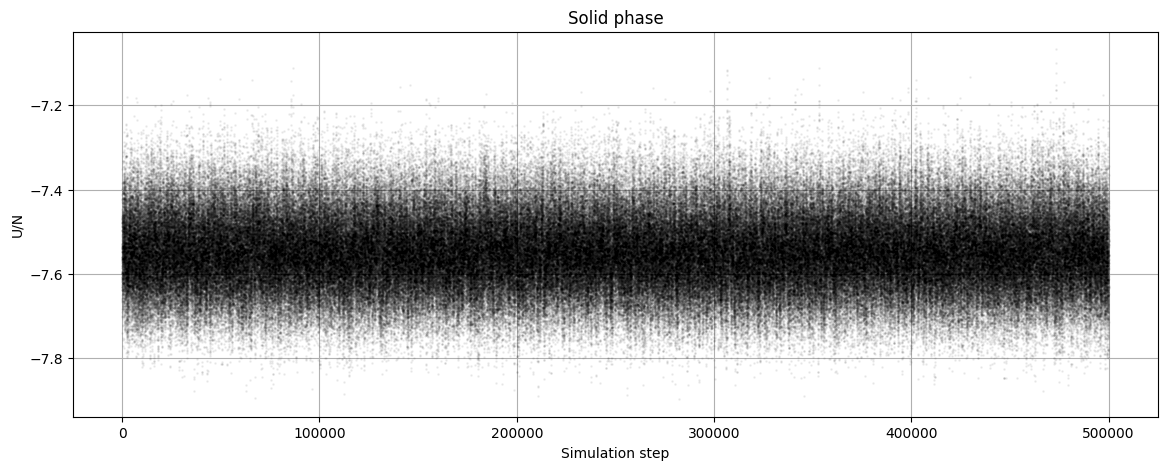

In [48]:
# Liste vuote per memorizzare i dati
step_solid = []
actual_pe_solid = []
        
# Lettura dei dati dal file
with open("OUTPUT/07.2/potential_energy_solid.dat", "r") as file:
    next(file)  # Salta la prima riga che contiene l'intestazione
    for line in file:
        data = line.split()
        step_solid.append(int(data[0])) 
        actual_pe_solid.append(float(data[1]))

plt.figure(figsize=(14, 5))

# Grafico
plt.plot(step_solid, actual_pe_solid, marker='o', linestyle='', markersize = 1, alpha = 0.05, color = 'black')
plt.xlabel('Simulation step')
plt.ylabel('U/N')
plt.title('Solid phase')
plt.grid(True)
plt.show()

In [49]:
autocorrelation_pe_solid = []

for i in range(1000):
    autocorrelation_pe_solid.append(Autocorrelation(actual_pe_solid,step_solid[i]))

In [55]:
N = [50000, 25000, 20000, 12500, 10000, 5000, 4000, 2500, 2000, 1000, 500, 250, 200, 125, 100]
stat_uncertainty_solid = []
L = []

for i in range(len(N)):
    stat_uncertainty_solid.append(stat_uncertainty(len(step_solid), N[i], actual_pe_solid))
    L.append(len(step_solid)/N[i])

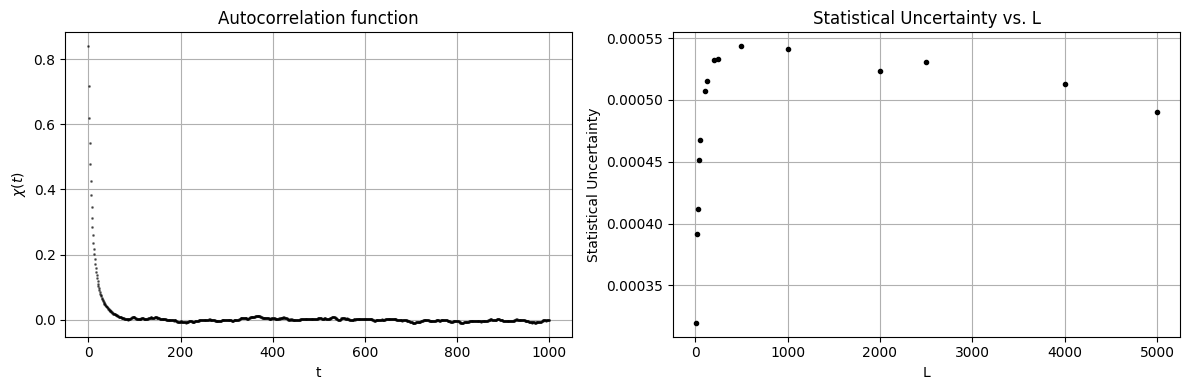

In [56]:
# Creazione dei subplot affiancati
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot dell'autocorrelation function
axs[0].plot(range(len(autocorrelation_pe_solid)), autocorrelation_pe_solid, marker='o', linestyle='', markersize=1, alpha=0.5, color='black')
axs[0].set_xlabel('t')
axs[0].set_ylabel('$\chi(t)$')
axs[0].set_title('Autocorrelation function')
axs[0].grid(True)

# Plot dell'incertezza statistica vs L
axs[1].plot(L, stat_uncertainty_solid, marker='o', markersize=3, linestyle='none', color='black')
axs[1].set_xlabel('L')
axs[1].set_ylabel('Statistical Uncertainty')
axs[1].set_title('Statistical Uncertainty vs. L')
axs[1].grid(True)

# Regola il layout per evitare sovrapposizioni
plt.tight_layout()

# Mostra il plot
plt.show()

#### Fase liquida

Ho individuato $\delta=0.11$ che garantisca l'accettazione richiesta nell'algoritmo di Metropolis..

I dati risultano avere autocorrelazione nulla a tempi leggermente maggiori rispetto alla fase solida, al $\textit{MC-t} \approx 200$ . Per quanto riguarda l'errore statistico, al di sotto di $L \approx 2000$ l'errore cresce rapidamente, mentre oltre quel valore tende a stabilizzarsi.


Ho quindi individuato $L=4000$ come lunghezza di blocco con cui effettuare la simulazione in queste condizioni termodinamiche all'esercizio successivo.

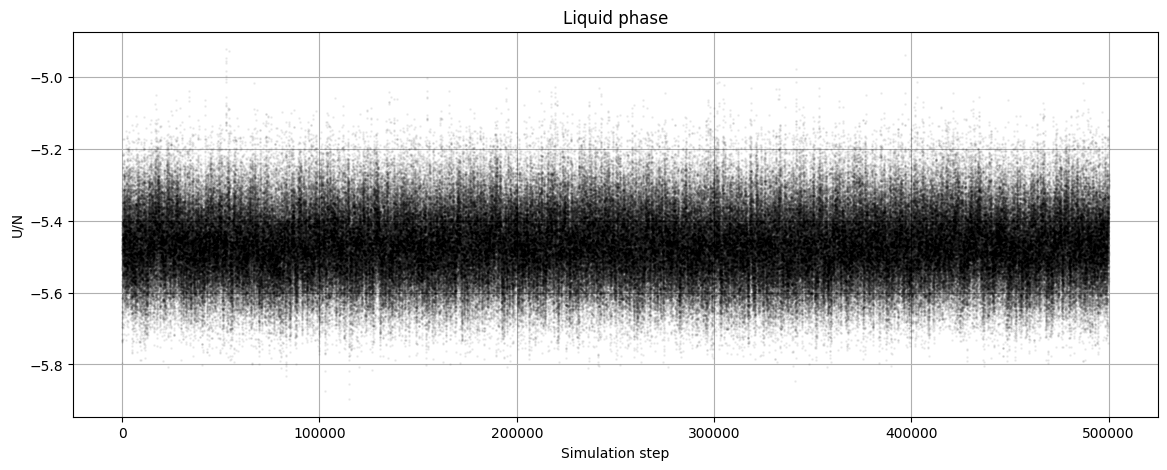

In [4]:
# Liste vuote per memorizzare i dati
step_liquid = []
actual_pe_liquid = []
        
# Lettura dei dati dal file
with open("OUTPUT/07.2/potential_energy_liquid.dat", "r") as file:
    next(file)  # Salta la prima riga che contiene l'intestazione
    for line in file:
        data = line.split()
        step_liquid.append(int(data[0])) 
        actual_pe_liquid.append(float(data[1]))

plt.figure(figsize=(14, 5))

# Grafico
plt.plot(step_liquid, actual_pe_liquid, marker='o', linestyle='', markersize = 1, alpha = 0.05, color = 'black')
plt.xlabel('Simulation step')
plt.ylabel('U/N')
plt.title('Liquid phase')
plt.grid(True)
plt.show()

In [5]:
autocorrelation_pe_liquid = []

for i in range(1000):
    autocorrelation_pe_liquid.append(Autocorrelation(actual_pe_liquid,step_liquid[i]))

In [57]:
N = [50000, 25000, 20000, 12500, 10000, 5000, 4000, 2500, 2000, 1000, 500, 250, 200, 125, 100]
stat_uncertainty_liquid = []
L = []

for i in range(len(N)):
    stat_uncertainty_liquid.append(stat_uncertainty(len(step_liquid), N[i], actual_pe_liquid))
    L.append(len(step_liquid)/N[i])

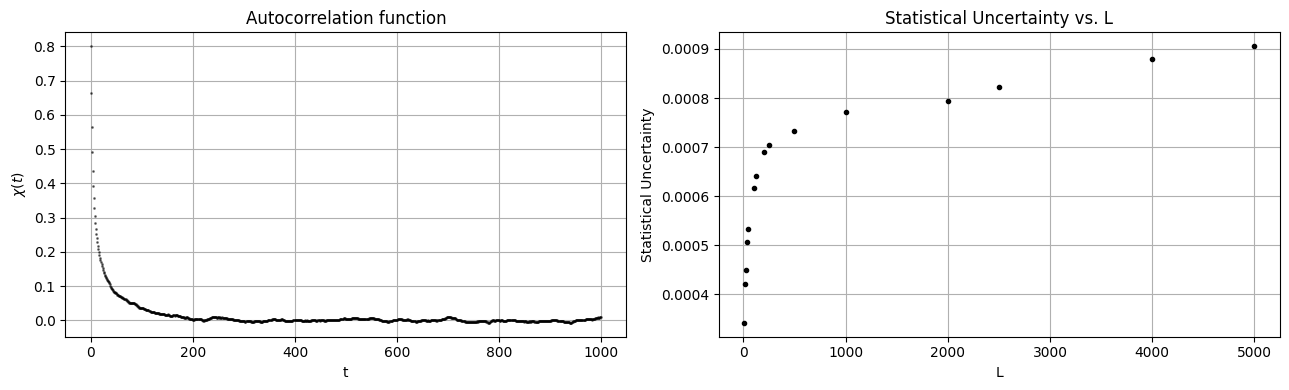

In [58]:
# Creazione dei subplot affiancati
fig, axs = plt.subplots(1, 2, figsize=(13, 4))

# Plot dell'autocorrelation function
axs[0].plot(range(len(autocorrelation_pe_liquid)), autocorrelation_pe_liquid, marker='o', linestyle='', markersize=1, alpha=0.5, color='black')
axs[0].set_xlabel('t')
axs[0].set_ylabel('$\chi(t)$')
axs[0].set_title('Autocorrelation function')
axs[0].grid(True)

# Plot dell'incertezza statistica vs L
axs[1].plot(L, stat_uncertainty_liquid, marker='o', markersize=3, linestyle='', linewidth=0.5, color='black')
axs[1].set_xlabel('L')
axs[1].set_ylabel('Statistical Uncertainty')
axs[1].set_title('Statistical Uncertainty vs. L')
axs[1].grid(True)

# Regola il layout per evitare sovrapposizioni
plt.tight_layout()

# Mostra il plot
plt.show()

#### Fase gassosa

Ho individuato $\delta=4.71$ che garantisca l'accettazione richiesta nell'algoritmo di Metropolis.

I dati risultano avere autocorrelazione nulla già al MC-$t \approx 50$ . Per quanto riguarda l'errore statistico, al di sotto di $L \approx 1000$ l'errore cresce velocemente, mentre oltre quel valore tende a stabilizzarsi intorno ad un valore, seppur con ampie oscillazioni.


Ho quindi individuato $L=2000$ come lunghezza di blocco con cui effettuare la simulazione in queste condizioni termodinamiche all'esercizio successivo.

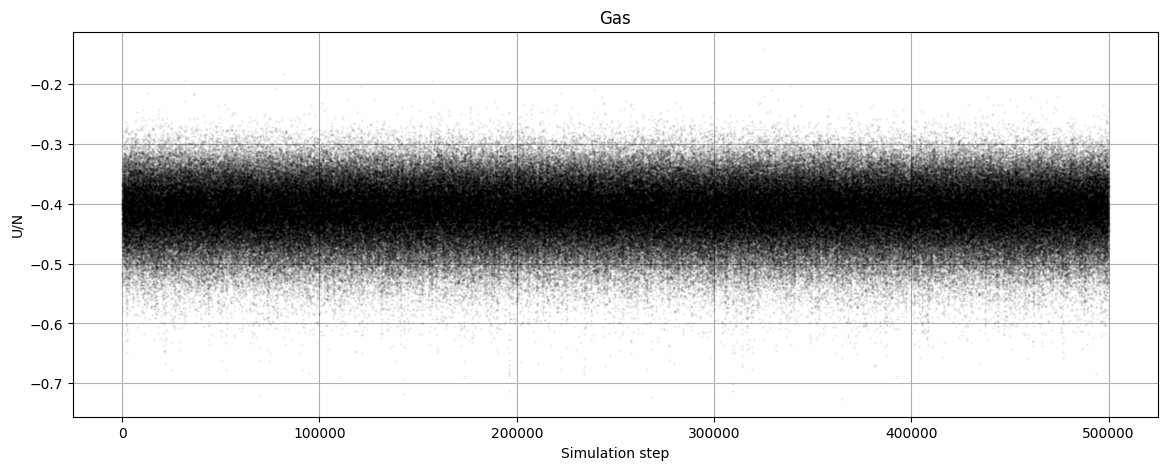

In [64]:
# Liste vuote per memorizzare i dati
step_gas = []
actual_pe_gas = []
        
# Lettura dei dati dal file
with open("OUTPUT/07.2/potential_energy_gas.dat", "r") as file:
    next(file)  # Salta la prima riga che contiene l'intestazione
    for line in file:
        data = line.split()
        step_gas.append(int(data[0])) 
        actual_pe_gas.append(float(data[1]))

plt.figure(figsize=(14, 5))

# Grafico
plt.plot(step_gas, actual_pe_gas, marker='o', linestyle='', markersize = 1, alpha = 0.05, color = 'black')
plt.xlabel('Simulation step')
plt.ylabel('U/N')
plt.title('Gas')
plt.grid(True)
plt.show()


In [65]:
autocorrelation_pe_gas = []

for i in range(1000):
    autocorrelation_pe_gas.append(Autocorrelation(actual_pe_gas,step_gas[i]))

In [66]:
N = [50000, 25000, 20000, 12500, 10000, 5000, 4000, 2500, 2000, 1000, 500, 250, 200, 125, 100]
stat_uncertainty_gas = []
L = []

for i in range(len(N)):
    stat_uncertainty_gas.append(stat_uncertainty(len(step_gas), N[i], actual_pe_gas))
    L.append(len(step_gas)/N[i])

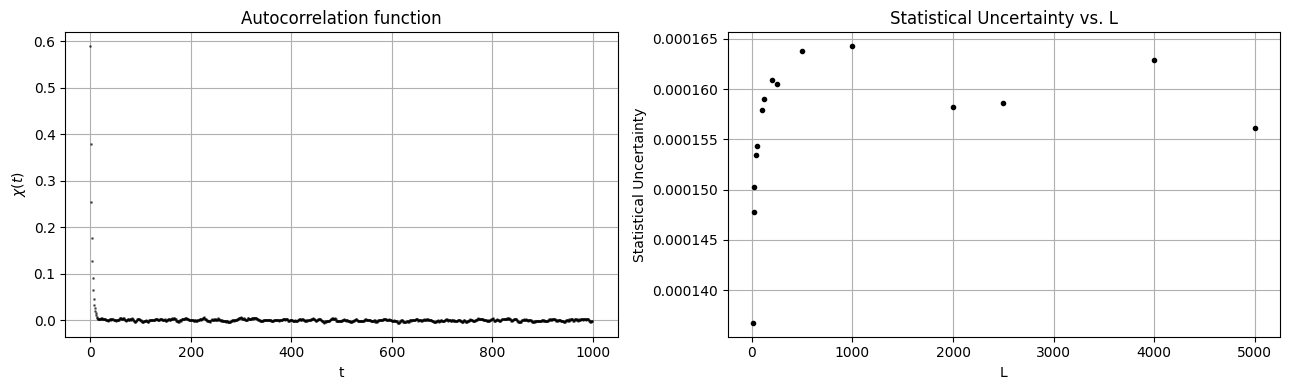

In [68]:
# Creazione dei subplot affiancati
fig, axs = plt.subplots(1, 2, figsize=(13, 4))

# Plot dell'autocorrelation function
axs[0].plot(range(len(autocorrelation_pe_gas)), autocorrelation_pe_gas, marker='o', linestyle='', markersize=1, alpha=0.5, color='black')
axs[0].set_xlabel('t')
axs[0].set_ylabel('$\chi(t)$')
axs[0].set_title('Autocorrelation function')
axs[0].grid(True)

# Plot dell'incertezza statistica vs L
axs[1].plot(L, stat_uncertainty_gas, marker='o', markersize=3, linestyle='', linewidth=0.5, color='black')
#axs[1].axvline(x=400, color='red', linestyle='--') 
axs[1].set_xlabel('L')
axs[1].set_ylabel('Statistical Uncertainty')
axs[1].set_title('Statistical Uncertainty vs. L')
axs[1].grid(True)

# Regola il layout per evitare sovrapposizioni
plt.tight_layout()

# Mostra il plot
plt.show()

#### Esercizio 07.3

Ho incluso nel codice della simulazione il calcolo della funzione di distribuzione radiale $g(r)$, $r$ distanza fra due molecole, $r \in \left[ 0; L/2\right]$.

#### Esercizio 07.4

Ho quindi utilizzato il codice MC fin qui sviluppato per misurare l'energia potenziale per particella $U/N$, la pressione $P$ e la funzione di distribuzione radiale $g(r)$ sul sistema, nelle tre fasi termodinamiche specificate sopra. La funzione radiale $g(r)$ ottenuta è stata poi confrontata con la funzione radiale ottenuta, nelle stesse condizioni di equilibrio, tramite simulazione di dinamica molecolare.

##### Fase solida

Ho equilibrato il sistema con un $M_{eq}=2000$ mosse (1 blocco).

I valori di input utilizzati sono stati:

```cpp
SIMULATION_TYPE        1 // LJ MONTE CARLO (NVT) SIMULATION
RESTART                0
TEMP                   0.8
NPART                  108
RHO                    1.1
R_CUT                  2.2
DELTA                  0.06 // TRANSITION PROBABILITY LENGHT TO OBTAIN METROPOLIS ACCEPTANCE RATIO OF APPROX 50% 
NBLOCKS                20
NSTEPS                 2000 // BLOCK LENGHT ESTABLISHED IN THE PREVIOUS EXERCISE

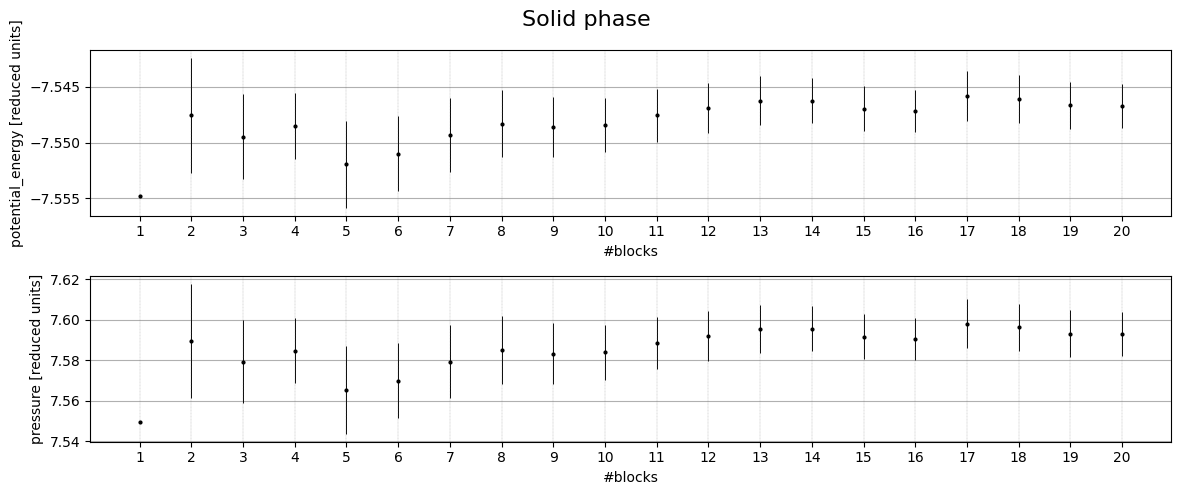

In [44]:
def load_data(file_path):
    blk, data, error = np.loadtxt(file_path, usecols=(0, 2, 3), unpack=True)
    return blk, data, error

# Define file paths
file_paths = ["OUTPUT/07.4/SOLID/NVT/potential_energy.dat", 
              "OUTPUT/07.4/SOLID/NVT/pressure.dat"]

# Load data and create subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 5))

for i, file_path in enumerate(file_paths):
    blk, data, error = load_data(file_path)
    axs[i].errorbar(blk, data, yerr=error,fmt='o', markersize=2, color='black', ecolor='black', linewidth=0.7)
    axs[i].set_xlabel('#blocks')
    axs[i].set_ylabel(file_path.split('/')[-1].split('.')[0] + ' [reduced units]')
    axs[i].grid(True, axis='y')  # Set grid only on y-axis
    axs[i].xaxis.set_major_locator(plt.MaxNLocator(integer=True))  # Set x-axis to show only integer values
    
     # Add vertical lines on integer values of x-axis
    for value in blk:
        axs[i].axvline(x=value, color='gray', linestyle='--', linewidth=0.2)
    
    # Set integer tick labels on the x-axis
    axs[i].set_xticks(blk)
    axs[i].set_xticklabels([int(x) for x in blk])

fig.suptitle('Solid phase', fontsize=16)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

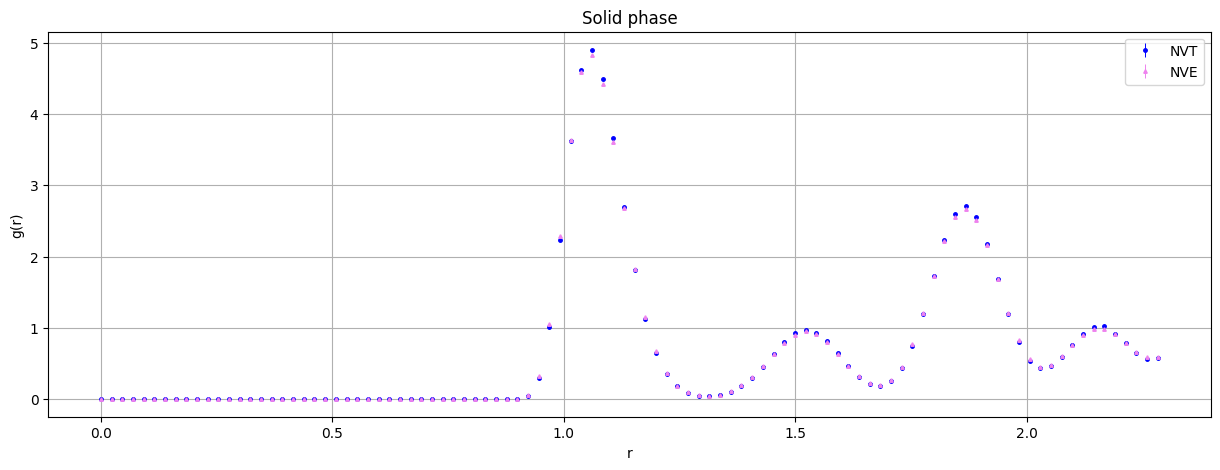

In [47]:
# Liste vuote per memorizzare i dati
r_nvt = []
gofr_nvt = []
gofr_error_nvt = []

r_nve = []
gofr_nve = []
gofr_error_nve = []
        
# Lettura dei dati dal file
with open("OUTPUT/07.4/SOLID/NVT/gofr.dat", "r") as file:
    next(file)  # Salta la prima riga che contiene l'intestazione
    for line in file:
        data = line.split()
        r_nvt.append(float(data[0])) 
        gofr_nvt.append(float(data[1]))
        gofr_error_nvt.append(float(data[2]))
with open("OUTPUT/07.4/SOLID/NVE/gofr.dat", "r") as file:
    next(file)  # Salta la prima riga che contiene l'intestazione
    for line in file:
        data = line.split()
        r_nve.append(float(data[0])) 
        gofr_nve.append(float(data[1]))
        gofr_error_nve.append(float(data[2]))

plt.figure(figsize=(15, 5))

# Grafico
plt.errorbar(r_nvt, gofr_nvt, yerr=gofr_error_nvt, fmt='o', markersize=2.5, color='blue', ecolor='blue', linewidth=0.7, label='NVT')
plt.errorbar(r_nve, gofr_nve, yerr=gofr_error_nve, fmt='^', markersize=2.5, color='violet', ecolor='violet', linewidth=0.7, label='NVE')
plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('Solid phase')
plt.grid(True)
plt.legend();
plt.show()

I valori ottenuti nelle due simulazioni sono compatibili.

L'alternarsi di picchi riflette la struttura reticolare del solido: il primo picco è posto in corrispondenza della distanza fra primi vicini, il secondo della distanza fra secondi vicini, ecc. La forma allargata del picco riflette invece la vibrazione delle molecole attorno al sito reticolare.

##### Fase liquida

Ho equilibrato il sistema con un $M_{eq}=4000$ mosse (1 blocco).

```cpp
I valori di input utilizzati sono stati:
SIMULATION_TYPE        1 // LJ MONTE CARLO (NVT) SIMULATION
RESTART                0
TEMP                   1.1
NPART                  108
RHO                    0.8
R_CUT                  2.5
DELTA                  0.11 // TRANSITION PROBABILITY LENGHT TO OBTAIN METROPOLIS ACCEPTANCE RATIO OF APPROX 50% 
NBLOCKS                20
NSTEPS                 4000 // BLOCK LENGHT ESTABLISHED IN THE PREVIOUS EXERCISE
 

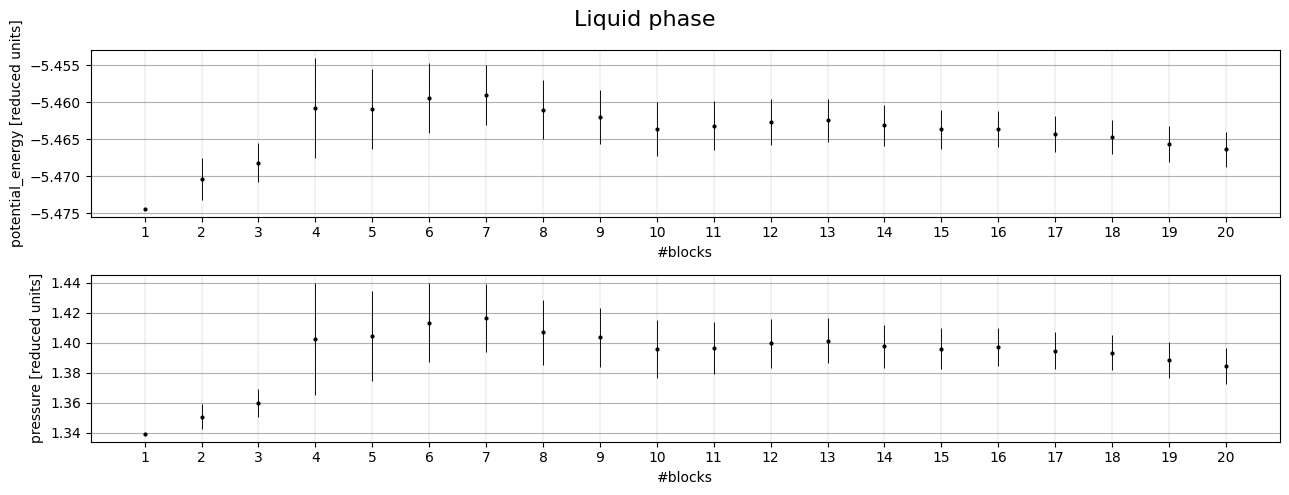

In [64]:
def load_data(file_path):
    blk, data, error = np.loadtxt(file_path, usecols=(0, 2, 3), unpack=True)
    return blk, data, error

# Define file paths
file_paths = ["OUTPUT/07.4/LIQUID/NVT/potential_energy.dat", 
              "OUTPUT/07.4/LIQUID/NVT/pressure.dat"]

# Load data and create subplots
fig, axs = plt.subplots(2, 1, figsize=(13, 5))

for i, file_path in enumerate(file_paths):
    blk, data, error = load_data(file_path)
    axs[i].errorbar(blk, data, yerr=error,fmt='o', markersize=2, color='black', ecolor='black', linewidth=0.7)
    axs[i].set_xlabel('#blocks')
    axs[i].set_ylabel(file_path.split('/')[-1].split('.')[0] + ' [reduced units]')
    axs[i].grid(True, axis='y')  # Set grid only on y-axis
    axs[i].xaxis.set_major_locator(plt.MaxNLocator(integer=True))  # Set x-axis to show only integer values
    
     # Add vertical lines on integer values of x-axis
    for value in blk:
        axs[i].axvline(x=value, color='gray', linestyle='--', linewidth=0.2)
    
    # Set integer tick labels on the x-axis
    axs[i].set_xticks(blk)
    axs[i].set_xticklabels([int(x) for x in blk])

fig.suptitle('Liquid phase', fontsize=16)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

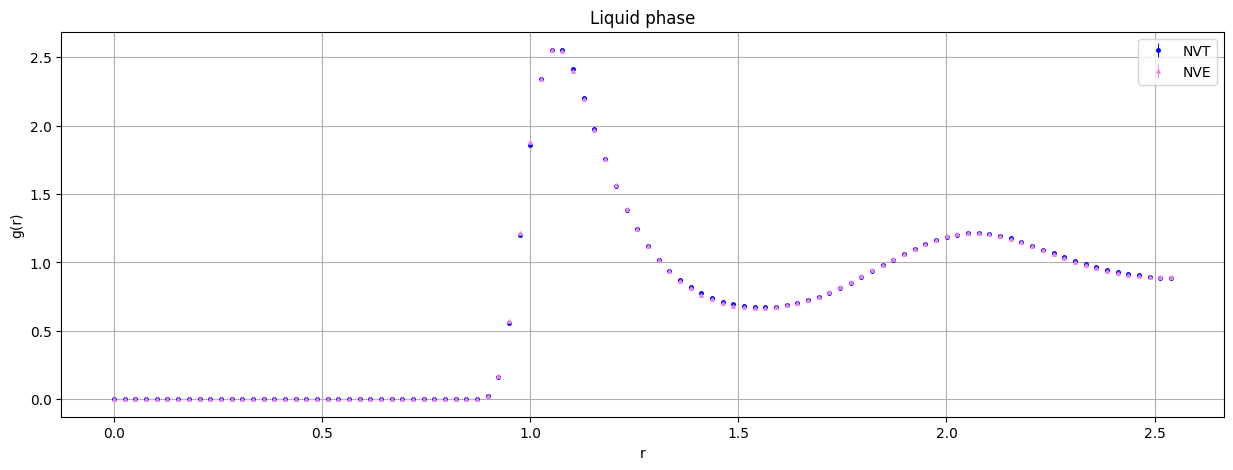

In [86]:
#Liste vuote per memorizzare i dati
r_nvt = []
gofr_nvt = []
gofr_error_nvt = []

r_nve = []
gofr_nve = []
gofr_error_nve = []

#Lettura dei dati dal file
with open("OUTPUT/07.4/LIQUID/NVT/gofr.dat", "r") as file:
    next(file) # Salta la prima riga che contiene l'intestazione
    for line in file:
        data = line.split()
        r_nvt.append(float(data[0]))
        gofr_nvt.append(float(data[1]))
        gofr_error_nvt.append(float(data[2]))
with open("OUTPUT/07.4/LIQUID/NVE/gofr.dat", "r") as file:
    next(file) # Salta la prima riga che contiene l'intestazione
    for line in file:
        data = line.split()
        r_nve.append(float(data[0]))
        gofr_nve.append(float(data[1]))
        gofr_error_nve.append(float(data[2]))

plt.figure(figsize=(15, 5))

#Grafico
plt.errorbar(r_nvt, gofr_nvt, yerr=gofr_error_nvt, fmt='o', markersize=2.5, color='blue', ecolor='blue', linewidth=0.7, label='NVT')
plt.errorbar(r_nve, gofr_nve, yerr=gofr_error_nve, fmt='^', markersize=2.5, color='violet', ecolor='violet', linewidth=0.7, label='NVE')
plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('Liquid phase')
plt.grid(True)
plt.legend();
plt.show()

Anche in questo caso i valori ottenuti nelle due simulazioni sono compatibili.

Rispetto alla $g(r)$ ottenuta nella fase solida, la funzione trovata presenta meno picchi e picchi meno accentuati.

##### Fase gassosa

Ho equilibrato il sistema con un $M_{eq}=2000$ mosse (1 blocco).

```cpp
I valori di input utilizzati sono stati:
SIMULATION_TYPE        1 // LJ MONTE CARLO (NVT) SIMULATION
RESTART                0
TEMP                   1.2
NPART                  108
RHO                    0.05
R_CUT                  5.0
DELTA                  4.71 // TRANSITION PROBABILITY LENGHT TO OBTAIN METROPOLIS ACCEPTANCE RATIO OF APPROX 50% 
NBLOCKS                20
NSTEPS                 2000 // BLOCK LENGHT ESTABLISHED IN THE PREVIOUS EXERCISE
 

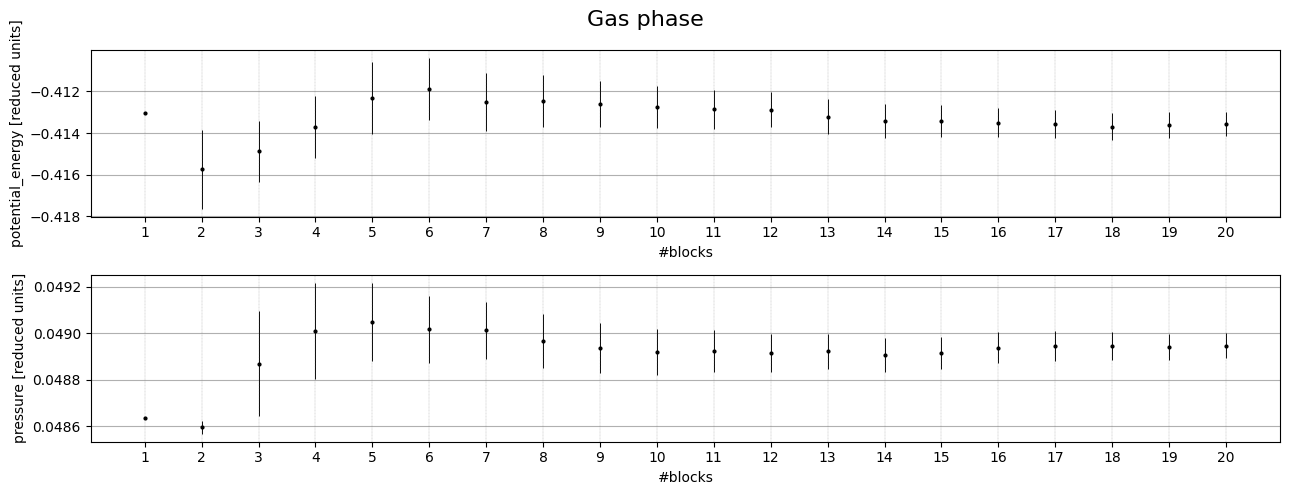

In [72]:
def load_data(file_path):
    blk, data, error = np.loadtxt(file_path, usecols=(0, 2, 3), unpack=True)
    return blk, data, error

# Define file paths
file_paths = ["OUTPUT/07.4/GAS/NVT/potential_energy.dat", 
              "OUTPUT/07.4/GAS/NVT/pressure.dat"]

# Load data and create subplots
fig, axs = plt.subplots(2, 1, figsize=(13, 5))

for i, file_path in enumerate(file_paths):
    blk, data, error = load_data(file_path)
    axs[i].errorbar(blk, data, yerr=error,fmt='o', markersize=2, color='black', ecolor='black', linewidth=0.7)
    axs[i].set_xlabel('#blocks')
    axs[i].set_ylabel(file_path.split('/')[-1].split('.')[0] + ' [reduced units]')
    axs[i].grid(True, axis='y')  # Set grid only on y-axis
    axs[i].xaxis.set_major_locator(plt.MaxNLocator(integer=True))  # Set x-axis to show only integer values
    
     # Add vertical lines on integer values of x-axis
    for value in blk:
        axs[i].axvline(x=value, color='gray', linestyle='--', linewidth=0.2)
    
    # Set integer tick labels on the x-axis
    axs[i].set_xticks(blk)
    axs[i].set_xticklabels([int(x) for x in blk])

fig.suptitle('Gas phase', fontsize=16)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

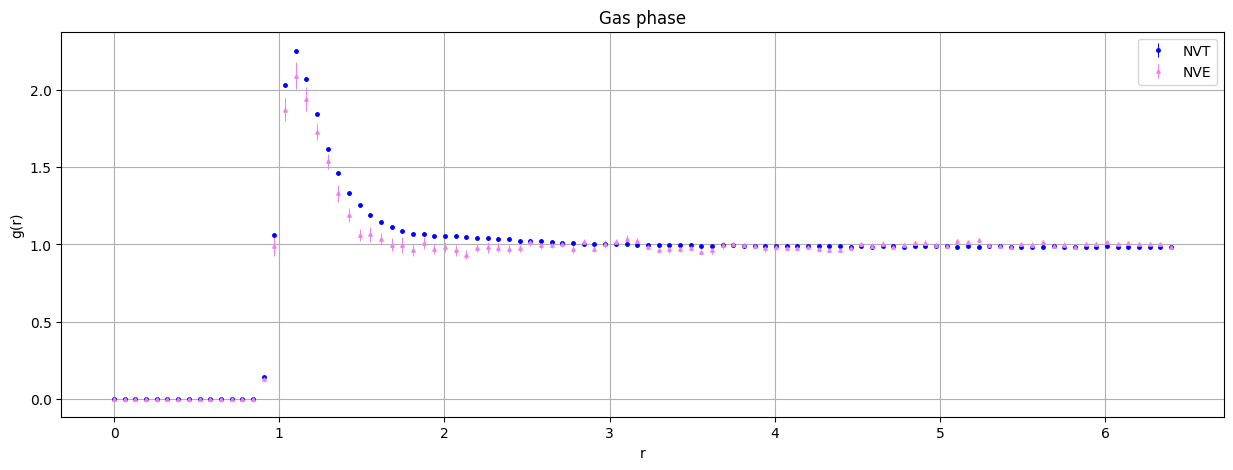

In [74]:
# Liste vuote per memorizzare i dati
r_nvt = []
gofr_nvt = []
gofr_error_nvt = []

r_nve = []
gofr_nve = []
gofr_error_nve = []
        
# Lettura dei dati dal file
with open("OUTPUT/07.4/GAS/NVT/gofr.dat", "r") as file:
    next(file)  # Salta la prima riga che contiene l'intestazione
    for line in file:
        data = line.split()
        r_nvt.append(float(data[0])) 
        gofr_nvt.append(float(data[1]))
        gofr_error_nvt.append(float(data[2]))
with open("OUTPUT/07.4/GAS/NVE/gofr.dat", "r") as file:
    next(file)  # Salta la prima riga che contiene l'intestazione
    for line in file:
        data = line.split()
        r_nve.append(float(data[0])) 
        gofr_nve.append(float(data[1]))
        gofr_error_nve.append(float(data[2]))

plt.figure(figsize=(15, 5))

# Grafico
plt.errorbar(r_nvt, gofr_nvt, yerr=gofr_error_nvt, fmt='o', markersize=2.5, color='blue', ecolor='blue', linewidth=0.7, label='NVT')
plt.errorbar(r_nve, gofr_nve, yerr=gofr_error_nve, fmt='^', markersize=2.5, color='violet', ecolor='violet', linewidth=0.7, label='NVE')
plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('Gas phase')
plt.grid(True)
plt.legend();
plt.show()

In questo caso, la discrepanza tra i valori ottenuti nelle due diverse simulazioni è maggiore, con discostamenti fino a $4 \sigma$. Va ricordato che nel caso di simulazione NVE, la temperatura finale raggiunta non è esattamente $T^{*}=1.1$.

La $g(r)$ in questo caso presenta un unico picco, che decade rapidamente ad 1 (indicando quindi una rapida coincidenza con la probabilità aspettata per una distribuzione randomica alla stessa densità).